Imports

In [13]:
import regex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
%matplotlib inline

Read data, remove one instance and set seed

In [14]:
seed = 42
df = pd.read_csv("aggr_sol_dataset.csv")
# Remove one instance
df = df[df["Uniprot_ID"] != "A0A3B3IS91"]

Add aggregator motif

In [15]:
aggregator_motifs = [
    'Q'*11,  # Huntington's polyQ motif - https://doi.org/10.1016/j.bpj.2018.02.037
    'EAKL',  # PDZ recognition motif - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3630890/
]
# Allow 1 AA error.
aggregator_patterns = [regex.compile(motif+'{e<=1}') for motif in aggregator_motifs]

def n_aggregator_motifs(sequence):
    sequence = str(sequence)
    n_motifs = 0
    for pattern in aggregator_patterns:
        n_motifs += 1 if (len(pattern.findall(sequence)) > 0) else 0
    return float(n_motifs)

# Add feature to dataframe.
df['n_aggregator_motifs'] = df['fasta_sequence'].apply(n_aggregator_motifs)

# Check correlation to existing numerical features
df.select_dtypes(np.number).corr()['n_aggregator_motifs'].sort_values(ascending=False)

n_aggregator_motifs    1.000000
tasa_netsurfp2         0.305171
thsa_netsurfp2         0.284101
molecular_weight       0.274251
length                 0.272834
                         ...   
rhsa_netsurfp2        -0.117449
F                     -0.127017
hydr_count            -0.147644
Gravy                 -0.151266
Aromaticity           -0.155745
Name: n_aggregator_motifs, Length: 97, dtype: float64

Only select numerical features (drop gene, gene name, uniprot ID)

In [16]:
numeric_df = df.select_dtypes(np.number)
# THSA and length: R2 = 0.8168
# TASA and length: R2 = 0.9013
# THSA and TASA: R2 = 0.9121
# corr_features = ["molecular_weight", "isoelectric_point_y", "thsa_netsurfp2", "tasa_netsurfp2", "Gravy", "P_exposed"]
numeric_df = numeric_df.drop(["molecular_weight", "isoelectric_point_y", "thsa_netsurfp2", "tasa_netsurfp2", "Gravy", "P_exposed"], axis=1)
# Hydr_count and gravy: R2 = 0.8304
# numeric_df = numeric_df.drop(['hydr_count'], axis=1)
# Add 'set' back to dataset
numeric_df['set'] = df['set']

# Select categorical features
categorical_features = df.columns[df.isin([0,1]).all()]
df_counts = df[categorical_features].apply(pd.Series.value_counts)
print('Categorical feature counts:', df_counts)

numeric_df

Categorical feature counts:       HSP  PTM_UP  Citrullination_UP  GPI-anchor_UP  Lipoprotein_UP  \
0.0  4277     527               4392           4416            4249   
1.0   143    3893                 28              4             171   

     Nitration_UP  Prenylation_UP  ISGylation_UP  NEDDylation_UP  \
0.0          4397            4357           4388            4408   
1.0            23              63             32              12   

     Acetylation_all  ...  Acetylation_MSD  Palmitoylation_MSD  \
0.0             1171  ...             3059                3801   
1.0             3249  ...             1361                 619   

     Methylation_MSD  coiled_coil   EGF  RAS_profile   RRM  ww_domain  \
0.0             2770         3976  4405         4377  4298       4393   
1.0             1650          444    15           43   122         27   

     transmembrane  TMHMM  
0.0           3612   3901  
1.0            808    519  

[2 rows x 33 columns]


,isoelectric_point_x,solubility,max_NX,LHPpred,length,hydr_count,polar_count,helix,turn,sheet,...,EGF,RAS_profile,RRM,ww_domain,transmembrane,TMHMM,Polar_exposed,Hydrophobic_exposed,n_aggregator_motifs,set
0,10.018646,-0.046652,54.0,1719.856274,8.022368,0.407692,0.388462,0.411538,0.411538,0.176923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.563636,0.200000,0.0,soluble
1,6.195928,0.238562,40.7,1719.856274,8.867279,0.436831,0.359743,0.289079,0.552463,0.158458,...,0.0,0.0,0.0,0.0,1.0,0.0,0.627586,0.172414,0.0,soluble
2,5.980819,0.136042,32.4,882.618646,9.315150,0.401884,0.422292,0.398744,0.489796,0.111460,...,0.0,0.0,0.0,0.0,0.0,0.0,0.711957,0.086957,0.0,soluble
3,4.359482,-0.898631,38.3,1015.981143,9.519636,0.374659,0.430518,0.403270,0.592643,0.004087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.617284,0.143210,1.0,aggregator
4,8.054211,0.230621,43.9,1247.199980,9.019591,0.433526,0.371869,0.391137,0.431599,0.177264,...,0.0,0.0,0.0,0.0,0.0,0.0,0.662338,0.162338,0.0,soluble
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4416,7.731725,-0.022040,13.1,1247.199980,9.921841,0.425773,0.392784,0.461856,0.430928,0.107216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.564706,0.144118,0.0,soluble
4417,6.617711,0.155722,2.8,1247.199980,8.022368,0.438462,0.380769,0.465385,0.380769,0.153846,...,0.0,0.0,0.0,0.0,1.0,1.0,0.623853,0.174312,0.0,soluble
4418,6.324807,-0.084824,10.7,955.075030,11.195987,0.428389,0.394288,0.387894,0.403666,0.208440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.736177,0.069510,1.0,soluble
4419,8.017299,0.078851,6.7,1247.199980,8.463524,0.390935,0.365439,0.252125,0.611898,0.135977,...,0.0,0.0,0.0,0.0,0.0,0.0,0.522727,0.198864,0.0,soluble


Data scaling

In [17]:
from sklearn.preprocessing import StandardScaler

# We want the aggregator class to be 'positive'
def convert_to_codes(category):
    if category == 'soluble':
        return 0
    elif category == 'aggregator':
        return 1

Xset = numeric_df.drop(['solubility', 'set'], axis='columns')   # features (set)
y1 = numeric_df['set'].apply(convert_to_codes)                  # target (set)

# Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
scaler.fit_transform(Xset)

array([[ 1.62612137,  0.09709979,  0.23911192, ..., -0.29429389,
         0.31675131, -0.45797324],
       [-0.48292477, -0.13748225,  0.23911192, ...,  0.40158198,
        -0.09578247, -0.45797324],
       [-0.60160327, -0.28387554, -0.54264007, ...,  1.31966502,
        -1.37374036, -0.45797324],
       ...,
       [-0.41182043, -0.66661465, -0.47498553, ...,  1.58322159,
        -1.63463772,  2.13057115],
       [ 0.52195037, -0.73716563, -0.20222037, ..., -0.73944977,
         0.29975773, -0.45797324],
       [ 1.10401953, -0.67366975,  0.23911192, ..., -0.85073875,
         1.15793346, -0.45797324]])

**Classification (y1)**

In [18]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss

# Split classification label "set" (y1) data into train, val and test using stratified split (80% train, 10% validation and 10% test)
Xset_train, Xset_val_test, y1_train, y1_val_test = train_test_split(Xset, y1, stratify=y1, test_size=0.2, random_state=seed)
Xset_val, Xset_test, y1_val, y1_test = train_test_split(Xset_val_test, y1_val_test, stratify=y1_val_test, test_size=0.5, random_state=seed)

# Oversampling
ros = RandomOverSampler(random_state=seed)
Xset_train_oversampled, y1_train_oversampled = ros.fit_resample(Xset_train, y1_train)

# Near-miss undersampling
nm = NearMiss()
Xset_train_undersampled, y1_train_undersampled = nm.fit_resample(Xset_train, y1_train)

Roc curve plotting

In [19]:
from sklearn.metrics import roc_curve, auc
import torch

def plot_roc(models, X_vals, y_validation_vals, labels, title=''):
    for model, X, y_val, label in zip(models, X_vals, y_validation_vals, labels):
        prob = model.predict_proba(X)
        curve = roc_curve(y_val, prob[:, 1])
        curve_auc = auc(curve[0], curve[1])
        plt.plot(curve[0], curve[1], label=f'{label.capitalize()} (area = {curve_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve'+title)
    plt.legend()


def plot_roc_NN(models, X_vals, y_validation_vals, labels, title=''):
    for model, X, y_val, label in zip(models, X_vals, y_validation_vals, labels):
        # Make predictions using the PyTorch model
        with torch.no_grad():
            model.eval()
            prob = torch.sigmoid(model(torch.tensor(X.to_numpy()).float())).numpy()
        
        curve = roc_curve(y_val, prob)
        curve_auc = auc(curve[0], curve[1])
        plt.plot(curve[0], curve[1], label=f'{label.capitalize()} (area = {curve_auc:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve ' + title)
    plt.legend()
    plt.show()

# Feedforward NN classification

In [20]:
# define the feedforward NN model
class NN_set_model(nn.Module):
    # currently has 1 hidden layer
    def __init__(self, input_size, hidden_size1, output_size):
        super(NN_set_model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

class NN_set_model2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NN_set_model2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [21]:
# some data converting (to tensors for compatibility)
X_set_train_tensor = torch.tensor(Xset_train.to_numpy(), dtype=torch.float32)
y_set_train_tensor = torch.tensor(y1_train, dtype=torch.float32).view(-1, 1)
# oversampled
X_set_train_tensor_ov = torch.tensor(Xset_train_oversampled.to_numpy(), dtype=torch.float32)
y_set_train_tensor_ov = torch.tensor(y1_train_oversampled, dtype=torch.float32).view(-1, 1)
# undersampled
X_set_train_tensor_un = torch.tensor(Xset_train_undersampled.to_numpy(), dtype=torch.float32)
y_set_train_tensor_un = torch.tensor(y1_train_undersampled, dtype=torch.float32).view(-1, 1)

X_set_val_tensor = torch.tensor(Xset_val.to_numpy(), dtype=torch.float32)
y_set_val_tensor = torch.tensor(y1_val.to_numpy(), dtype=torch.float32).view(-1, 1)

X_set_test_tensor = torch.tensor(Xset_test.to_numpy(), dtype=torch.float32)
y_set_test_tensor = torch.tensor(y1_test.to_numpy(), dtype=torch.float32).view(-1, 1)

Feedforward NN classification scores:
Epoch 10/200, validation accuracy: 0.5
Epoch 20/200, validation accuracy: 0.5
Epoch 30/200, validation accuracy: 0.5844547964113181
Epoch 40/200, validation accuracy: 0.5
Epoch 50/200, validation accuracy: 0.5
Epoch 60/200, validation accuracy: 0.5332988267770876
Epoch 70/200, validation accuracy: 0.49879227053140096
Epoch 80/200, validation accuracy: 0.5308833678398895
Epoch 90/200, validation accuracy: 0.5535714285714286
Epoch 100/200, validation accuracy: 0.49879227053140096
Epoch 110/200, validation accuracy: 0.5665976535541752
Epoch 120/200, validation accuracy: 0.5178571428571429
Epoch 130/200, validation accuracy: 0.5320910973084886
Epoch 140/200, validation accuracy: 0.5178571428571429
Epoch 150/200, validation accuracy: 0.5653899240855762
Epoch 160/200, validation accuracy: 0.5702208419599724
Epoch 170/200, validation accuracy: 0.5856625258799172
Epoch 180/200, validation accuracy: 0.5511559696342305
Epoch 190/200, validation accuracy: 0.5

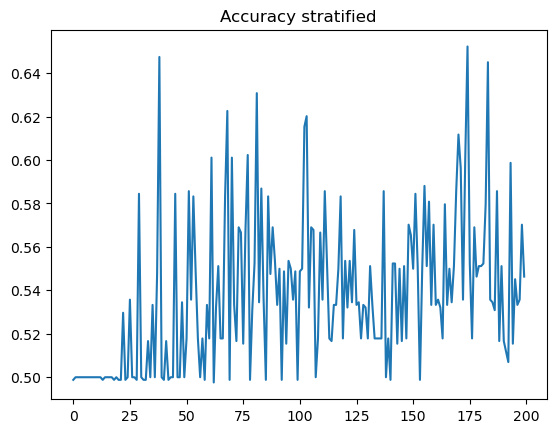

Epoch 10/200, validation accuracy: 0.693926846100759
Epoch 20/200, validation accuracy: 0.6948757763975155
Epoch 30/200, validation accuracy: 0.7120427881297446
Epoch 40/200, validation accuracy: 0.7359385783298826
Epoch 50/200, validation accuracy: 0.7084195997239475
Epoch 60/200, validation accuracy: 0.6847826086956521
Epoch 70/200, validation accuracy: 0.7214458247066943
Epoch 80/200, validation accuracy: 0.690303657694962
Epoch 90/200, validation accuracy: 0.6693409247757074
Epoch 100/200, validation accuracy: 0.687888198757764
Epoch 110/200, validation accuracy: 0.6666666666666667
Epoch 120/200, validation accuracy: 0.689872325741891
Epoch 130/200, validation accuracy: 0.6871980676328502
Epoch 140/200, validation accuracy: 0.6862491373360939
Epoch 150/200, validation accuracy: 0.6744306418219461
Epoch 160/200, validation accuracy: 0.6751207729468599
Epoch 170/200, validation accuracy: 0.6932367149758454
Epoch 180/200, validation accuracy: 0.6514837819185645
Epoch 190/200, validati

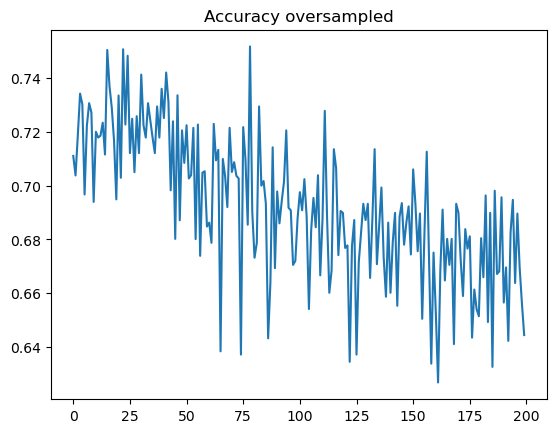

Epoch 10/200, validation accuracy: 0.5
Epoch 20/200, validation accuracy: 0.5
Epoch 30/200, validation accuracy: 0.5
Epoch 40/200, validation accuracy: 0.5
Epoch 50/200, validation accuracy: 0.5
Epoch 60/200, validation accuracy: 0.5
Epoch 70/200, validation accuracy: 0.5
Epoch 80/200, validation accuracy: 0.5
Epoch 90/200, validation accuracy: 0.5
Epoch 100/200, validation accuracy: 0.5
Epoch 110/200, validation accuracy: 0.5
Epoch 120/200, validation accuracy: 0.5
Epoch 130/200, validation accuracy: 0.5
Epoch 140/200, validation accuracy: 0.5
Epoch 150/200, validation accuracy: 0.5
Epoch 160/200, validation accuracy: 0.5
Epoch 170/200, validation accuracy: 0.5
Epoch 180/200, validation accuracy: 0.5
Epoch 190/200, validation accuracy: 0.5
Epoch 200/200, validation accuracy: 0.5
Undersampled: 0.5


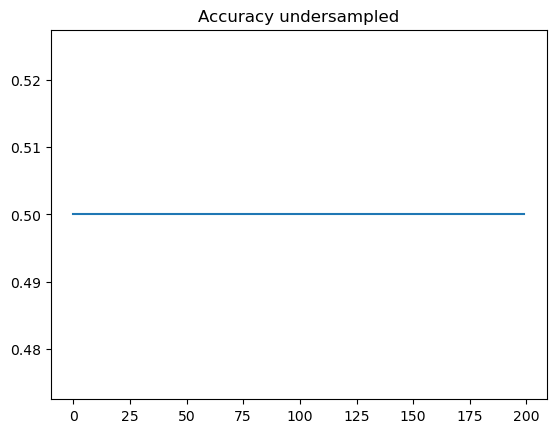

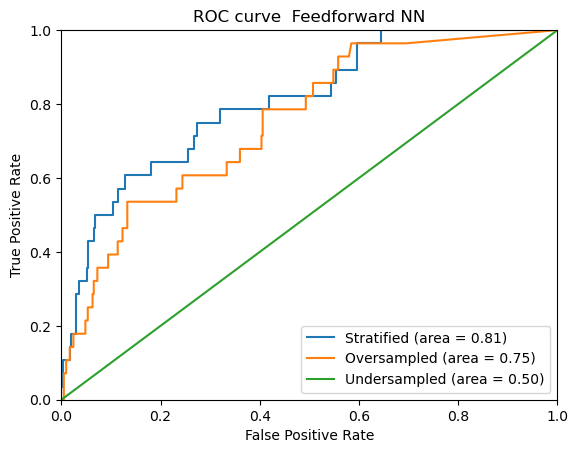

In [22]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# initiate model
num_epochs = 200
learning_rate = 0.001
batch_size = 16
input_size = Xset_train.shape[1]
hidden_size1 = 58
hidden_size2 = 32
output_size = 1
model = NN_set_model2(input_size, hidden_size1, hidden_size2, output_size)
model_oversampled = NN_set_model2(input_size, hidden_size1, hidden_size2, output_size)
model_undersampled = NN_set_model2(input_size, hidden_size1, hidden_size2, output_size)
# model = NN_set_model2(input_size, hidden_size1, hidden_size2, output_size)

# loss function and optimizer, BCE loss is best suited for binary classification instead of cross entropy (more suited for multi class)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

criterion_oversampled = nn.BCELoss()
optimizer_oversampled = optim.Adam(model_oversampled.parameters(), lr=learning_rate)

criterion_undersampled = nn.BCELoss()
optimizer_undersampled = optim.Adam(model_undersampled.parameters(), lr=learning_rate)

# convert data to PyTorch datasets and data loaders
train_dataset_set = TensorDataset(X_set_train_tensor, y_set_train_tensor)
train_dataset_set_ov = TensorDataset(X_set_train_tensor_ov, y_set_train_tensor_ov) # oversampled
train_dataset_set_un = TensorDataset(X_set_train_tensor_un, y_set_train_tensor_un) # undersampled

val_dataset_set = TensorDataset(X_set_val_tensor, y_set_val_tensor)
test_dataset_set = TensorDataset(X_set_test_tensor, y_set_test_tensor)

train_loader_set = DataLoader(train_dataset_set, batch_size=batch_size, shuffle=True)
train_loader_set_ov = DataLoader(train_dataset_set_ov, batch_size=batch_size, shuffle=True) # oversampled
train_loader_set_un = DataLoader(train_dataset_set_un, batch_size=batch_size, shuffle=True) # undersampled
val_loader_set = DataLoader(val_dataset_set, batch_size=len(val_dataset_set), shuffle=False)
test_loader_set = DataLoader(test_dataset_set, batch_size=len(test_dataset_set), shuffle=False)

print('Feedforward NN classification scores:')
# Stratified
accuracy_val_list = []
for epoch in range(1, num_epochs + 1):
  model.train()
  for inputs, labels in train_loader_set:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

  # evaluate the model with the validation dataset
  model.eval()
  with torch.no_grad():
      val_outputs = model(X_set_val_tensor)
      val_predictions = (val_outputs > 0.5).float()
  accuracy_val = balanced_accuracy_score(y_set_val_tensor, val_predictions.numpy())
  accuracy_val_list.append(accuracy_val)
  if epoch % 10 == 0:
    print(f"Epoch {epoch}/{num_epochs}, validation accuracy: {accuracy_val}")

model.eval()
with torch.no_grad():
    test_outputs = model(X_set_test_tensor)
    test_predictions = (test_outputs > 0.5).float()
print('Stratified:', balanced_accuracy_score(y_set_test_tensor, test_predictions.numpy()))

plt.plot(range(num_epochs), accuracy_val_list)
# plt.ylim(bottom=0, top=1)
plt.title("Accuracy stratified")
plt.show()

# Oversampled
accuracy_val_list_ov = []
for epoch in range(1, num_epochs + 1):
  model_oversampled.train()
  for inputs, labels in train_loader_set_ov:
      optimizer_oversampled.zero_grad()
      outputs = model_oversampled(inputs)
      loss = criterion_oversampled(outputs, labels)
      loss.backward()
      optimizer_oversampled.step()

  # evaluate the model with the validation dataset
  model_oversampled.eval()
  with torch.no_grad():
      val_outputs = model_oversampled(X_set_val_tensor)
      val_predictions = (val_outputs > 0.5).float()
  accuracy_val = balanced_accuracy_score(y_set_val_tensor, val_predictions.numpy())
  accuracy_val_list_ov.append(accuracy_val)
  if epoch % 10 == 0:
    print(f"Epoch {epoch}/{num_epochs}, validation accuracy: {accuracy_val}")

model_oversampled.eval()
with torch.no_grad():
    test_outputs = model_oversampled(X_set_test_tensor)
    test_predictions = (test_outputs > 0.5).float()
print('Oversampled:', balanced_accuracy_score(y_set_test_tensor, test_predictions.numpy()))

plt.plot(range(num_epochs), accuracy_val_list_ov)
# plt.ylim(bottom=0, top=1)
plt.title("Accuracy oversampled")
plt.show()

# Undersampled
accuracy_val_list_un = []
for epoch in range(1, num_epochs + 1):
  model_undersampled.train()
  for inputs, labels in train_loader_set_un:
      optimizer_undersampled.zero_grad()
      outputs = model_undersampled(inputs)
      loss = criterion_undersampled(outputs, labels)
      loss.backward()
      optimizer_undersampled.step()

  # evaluate the model with the validation dataset
  model_undersampled.eval()
  with torch.no_grad():
      val_outputs = model_undersampled(X_set_val_tensor)
      val_predictions = (val_outputs > 0.5).float()
  accuracy_val = balanced_accuracy_score(y_set_val_tensor, val_predictions.numpy())
  accuracy_val_list_un.append(accuracy_val)
  if epoch % 10 == 0:
    print(f"Epoch {epoch}/{num_epochs}, validation accuracy: {accuracy_val}")

model_undersampled.eval()
with torch.no_grad():
    test_outputs = model_undersampled(X_set_test_tensor)
    test_predictions = (test_outputs > 0.5).float()
print('Undersampled:', balanced_accuracy_score(y_set_test_tensor, test_predictions.numpy()))

plt.plot(range(num_epochs), accuracy_val_list_un)
# plt.ylim(bottom=0, top=1)
plt.title("Accuracy undersampled")
plt.show()

# ROC curves
plot_roc_NN(
    (model, model_oversampled, model_undersampled),
    (Xset_val, Xset_val, Xset_val),
    (y1_val, y1_val, y1_val, y1_val),
    ('stratified', 'oversampled', 'undersampled'),
    ' Feedforward NN'
)

# Random forest classification

Random forest classification scores:
Stratified: 0.5
Oversampled: 0.711783988957902
Undersampled: 0.6370772946859904


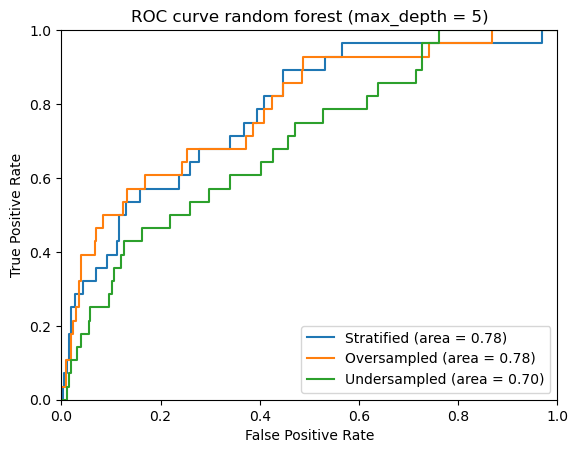

In [23]:
from sklearn.ensemble import RandomForestClassifier

print('Random forest classification scores:')
# Stratified
forest_stratified = RandomForestClassifier(max_depth=5, random_state=seed)
forest_stratified.fit(Xset_train, y1_train)
print('Stratified:', balanced_accuracy_score(y1_val, forest_stratified.predict(Xset_val)))

# Oversampled
forest_oversampled = RandomForestClassifier(max_depth=5, random_state=seed)
forest_oversampled.fit(Xset_train_oversampled, y1_train_oversampled)
print('Oversampled:', balanced_accuracy_score(y1_val, forest_oversampled.predict(Xset_val)))

# Undersampled
forest_undersampled = RandomForestClassifier(max_depth=5, random_state=seed)
forest_undersampled.fit(Xset_train_undersampled, y1_train_undersampled)
print('Undersampled:', balanced_accuracy_score(y1_val, forest_undersampled.predict(Xset_val)))

plot_roc(
    (forest_stratified, forest_oversampled, forest_undersampled),
    (Xset_val, Xset_val, Xset_val),
    (y1_val, y1_val, y1_val, y1_val),
    ('stratified', 'oversampled', 'undersampled'),
    ' random forest (max_depth = 5)'
)

# k-nearest neighbors

In [24]:
print(Xset_train_oversampled.shape)
print(Xset_train_undersampled.shape)

(6626, 90)
(446, 90)


k-nearest neighbors classification scores:
Stratified: 0.5436507936507936
Oversampled: 0.5436507936507936
Undersampled: 0.48248792270531404
k-nearest neighbors classification scores:
Stratified: 0.5617667356797792
Oversampled: 0.5658212560386473
Undersampled: 0.5269151138716356
k-nearest neighbors classification scores:
Stratified: 0.5130262249827467
Oversampled: 0.6024844720496895
Undersampled: 0.5595238095238095
k-nearest neighbors classification scores:
Stratified: 0.49879227053140096
Oversampled: 0.5855762594893029
Undersampled: 0.5276915113871636
k-nearest neighbors classification scores:
Stratified: 0.5
Oversampled: 0.5901483781918565
Undersampled: 0.474120082815735
k-nearest neighbors classification scores:
Stratified: 0.5
Oversampled: 0.6113699102829537
Undersampled: 0.45747066942719117
k-nearest neighbors classification scores:
Stratified: 0.5
Oversampled: 0.6135265700483092
Undersampled: 0.5062111801242236
k-nearest neighbors classification scores:
Stratified: 0.5
Oversampled

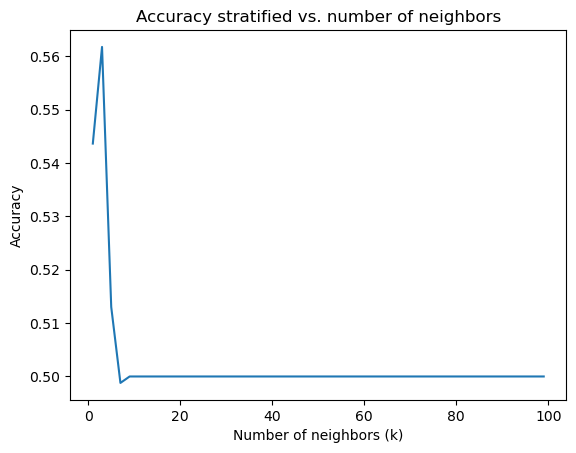

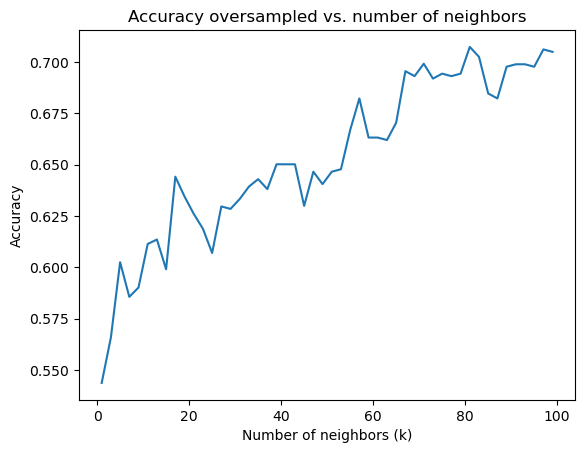

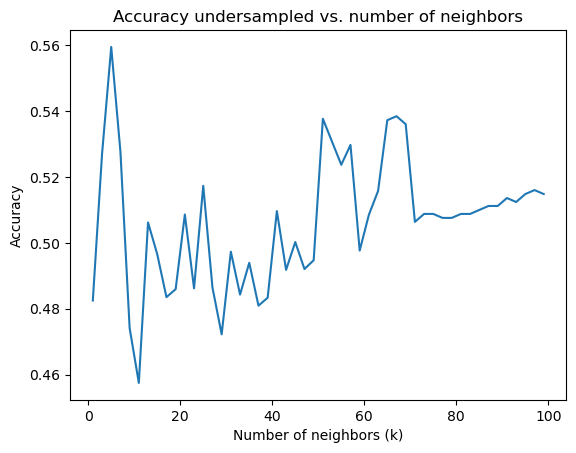

In [25]:
from sklearn.neighbors import KNeighborsClassifier
k_acc = []
k_acc_oversampled = []
k_acc_undersampled = []
k_values = range(1, 100, 2)

for k in k_values:
    print('k-nearest neighbors classification scores:')
    # Stratified
    knn_stratified = KNeighborsClassifier(n_neighbors=k)
    knn_stratified.fit(Xset_train.values, y1_train)  # see: https://github.com/scikit-learn/scikit-learn/issues/26768
    knn_acc_stratified = balanced_accuracy_score(y1_val, knn_stratified.predict(Xset_val.values))
    k_acc.append(knn_acc_stratified)
    print('Stratified:', balanced_accuracy_score(y1_val, knn_stratified.predict(Xset_val.values)))
    
    # Oversampled
    knn_oversampled = KNeighborsClassifier(n_neighbors=k)
    knn_oversampled.fit(Xset_train_oversampled.values, y1_train_oversampled)
    knn_acc_oversampled = balanced_accuracy_score(y1_val, knn_oversampled.predict(Xset_val.values))
    k_acc_oversampled.append(knn_acc_oversampled)
    print('Oversampled:', balanced_accuracy_score(y1_val, knn_oversampled.predict(Xset_val.values)))
    
    # Undersampled
    knn_undersampled = KNeighborsClassifier(n_neighbors=k)
    knn_undersampled.fit(Xset_train_undersampled.values, y1_train_undersampled)
    knn_acc_undersampled = balanced_accuracy_score(y1_val, knn_undersampled.predict(Xset_val.values))
    k_acc_undersampled.append(knn_acc_undersampled)
    print('Undersampled:', balanced_accuracy_score(y1_val, knn_undersampled.predict(Xset_val.values)))
    
    # plot_roc(
    #     (knn_stratified, knn_oversampled, knn_undersampled),
    #     (Xset_val.values, Xset_val.values, Xset_val.values),
    #     (y1_val, y1_val, y1_val, y1_val),
    #     ('stratified', 'oversampled', 'undersampled'),
    #     f' knn (n_neighbors = {k})'
    # )
    # plt.show()

# Stratified
plt.plot(k_values, k_acc)
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy stratified vs. number of neighbors')
plt.show()

# Oversampled
plt.plot(k_values, k_acc_oversampled)
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy oversampled vs. number of neighbors')
plt.show()

# Undersampled
plt.plot(k_values, k_acc_undersampled)
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy undersampled vs. number of neighbors')
plt.show()

Oversampled: 0.707384403036577
Stratified: 0.5130262249827467
Undersampled: 0.5237232574189096


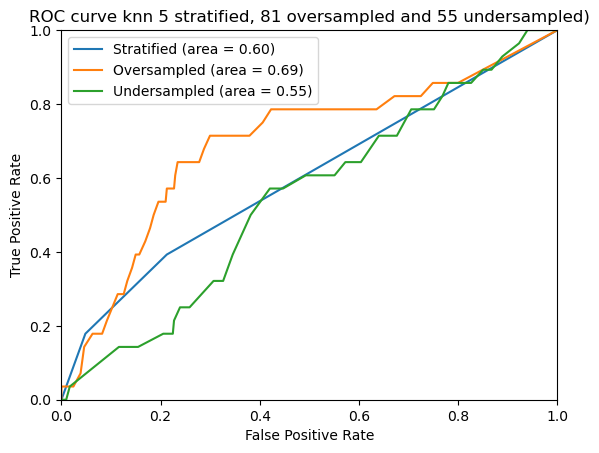

In [26]:
knn_stratified = KNeighborsClassifier(n_neighbors=5)
knn_stratified.fit(Xset_train.values, y1_train)
knn_oversampled = KNeighborsClassifier(n_neighbors=81)
knn_oversampled.fit(Xset_train_oversampled.values, y1_train_oversampled)
knn_undersampled = KNeighborsClassifier(n_neighbors=55)
knn_undersampled.fit(Xset_train_undersampled.values, y1_train_undersampled)
# accuracies
knn_acc_oversampled = balanced_accuracy_score(y1_val, knn_oversampled.predict(Xset_val.values))
print('Oversampled:', balanced_accuracy_score(y1_val, knn_oversampled.predict(Xset_val.values)))
knn_acc_stratified = balanced_accuracy_score(y1_val, knn_stratified.predict(Xset_val.values))
print('Stratified:', balanced_accuracy_score(y1_val, knn_stratified.predict(Xset_val.values)))
knn_acc_undersampled = balanced_accuracy_score(y1_val, knn_undersampled.predict(Xset_val.values))
print('Undersampled:', balanced_accuracy_score(y1_val, knn_undersampled.predict(Xset_val.values)))

plot_roc(
    (knn_stratified, knn_oversampled, knn_undersampled),
    (Xset_val.values, Xset_val.values, Xset_val.values),
    (y1_val, y1_val, y1_val, y1_val),
    ('stratified', 'oversampled', 'undersampled'),
    f' knn 5 stratified, 81 oversampled and 55 undersampled)'
)
plt.show()

Grid search on random forest

In [27]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve

# Plotting on the model
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix

# Plotting on the model
def plot_model(model, title='Optimized random forest model', validation=[Xset_val, y1_val]):
    # Initialize figure
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(title)

    # Precision recall curves
    PrecisionRecallDisplay.from_estimator(
        model, *validation, name='Random forest', pos_label=1, plot_chance_level=True, ax=ax[0]
    )
    ax[0].set_title('Precision-Recall curve (aggregator)')
    PrecisionRecallDisplay.from_estimator(
        model, *validation, name='Random forest', pos_label=0, plot_chance_level=True, ax=ax[1]
    )
    ax[1].set_title('Precision-Recall curve (soluble)')

    # ROC curve
    RocCurveDisplay.from_estimator(
        model, *validation, name='Random forest', plot_chance_level=True, ax=ax[2]
    )
    ax[2].set_title("ROC curve")

    # Confusion matrix
    cm = confusion_matrix(validation[1], model.predict(validation[0]))
    ConfusionMatrixDisplay(cm).plot(ax=ax[3], cmap='Blues')
    ax[3].set_title("Confusion matrix")
    ax[3].set_xticks([0,1], labels=['soluble', 'aggregator'])
    ax[3].set_yticks([0,1], labels=['soluble', 'aggregator'])

    # Printing values
    print('Specificity', recall_score(validation[1], model.predict(validation[0]), pos_label=1))
    print('Sensitivity', recall_score(validation[1], model.predict(validation[0]), pos_label=0))

    # Show plot
    plt.tight_layout()
    plt.show()


# Plotting on the model KNN
def plot_model_KNN(model, title='Optimized KNN model', validation=[Xset_val, y1_val]):
    # Initialize figure
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(title)

    # Precision recall curves
    PrecisionRecallDisplay.from_estimator(
        model, *validation, name='KNN', pos_label=1, plot_chance_level=True, ax=ax[0]
    )
    ax[0].set_title('Precision-Recall curve (aggregator)')
    PrecisionRecallDisplay.from_estimator(
        model, *validation, name='KNN', pos_label=0, plot_chance_level=True, ax=ax[1]
    )
    ax[1].set_title('Precision-Recall curve (soluble)')

    # ROC curve
    RocCurveDisplay.from_estimator(
        model, *validation, name='Random forest', plot_chance_level=True, ax=ax[2]
    )
    ax[2].set_title("ROC curve")

    # Confusion matrix
    cm = confusion_matrix(validation[1], model.predict(validation[0]))
    ConfusionMatrixDisplay(cm).plot(ax=ax[3], cmap='Blues')
    ax[3].set_title("Confusion matrix")
    ax[3].set_xticks([0,1], labels=['soluble', 'aggregator'])
    ax[3].set_yticks([0,1], labels=['soluble', 'aggregator'])

    # Printing values
    print('Specificity', recall_score(validation[1], model.predict(validation[0]), pos_label=1))
    print('Sensitivity', recall_score(validation[1], model.predict(validation[0]), pos_label=0))

    # Show plot
    plt.tight_layout()
    plt.show()

# Plotting on the model
def plot_model_baseline(model, title='Baseline model', validation=[Xset_val, y1_val]):
    # Initialize figure
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(title)

    # Precision recall curves
    PrecisionRecallDisplay.from_estimator(
        model, *validation, name='Baseline', pos_label=1, plot_chance_level=True, ax=ax[0]
    )
    ax[0].set_title('Precision-Recall curve (aggregator)')
    PrecisionRecallDisplay.from_estimator(
        model, *validation, name='Baseline', pos_label=0, plot_chance_level=True, ax=ax[1]
    )
    ax[1].set_title('Precision-Recall curve (soluble)')

    # ROC curve
    RocCurveDisplay.from_estimator(
        model, *validation, name='Baseline', plot_chance_level=True, ax=ax[2]
    )
    ax[2].set_title("ROC curve")

    # Confusion matrix
    cm = confusion_matrix(validation[1], model.predict(validation[0]))
    ConfusionMatrixDisplay(cm).plot(ax=ax[3], cmap='Blues')
    ax[3].set_title("Confusion matrix")
    ax[3].set_xticks([0,1], labels=['soluble', 'aggregator'])
    ax[3].set_yticks([0,1], labels=['soluble', 'aggregator'])

    # Printing values
    print('Specificity', recall_score(validation[1], model.predict(validation[0]), pos_label=1))
    print('Sensitivity', recall_score(validation[1], model.predict(validation[0]), pos_label=0))

    # Show plot
    plt.tight_layout()
    plt.show()


# plot nn model
def plot_model_nn(model, title='Neural network', validation=[Xset_val, y1_val]):
    # Convert data to PyTorch tensors
    X_val_tensor = torch.tensor(validation[0].values, dtype=torch.float32)
    y_val_tensor = torch.tensor(validation[1].values, dtype=torch.float32)

    # Make predictions using the PyTorch model
    with torch.no_grad():
        model.eval()
        predictions = torch.sigmoid(model(X_val_tensor)).numpy()

    # Initialize figure
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(title)

    # Precision-recall curves
    precision, recall, _ = precision_recall_curve(y_val_tensor, predictions)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax[0])
    ax[0].set_title('Precision-Recall curve (aggregator)')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')

    precision, recall, _ = precision_recall_curve(1 - y_val_tensor, 1 - predictions)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax[1])
    ax[1].set_title('Precision-Recall curve (soluble)')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')

    # ROC curve
    fpr, tpr, _ = roc_curve(y_val_tensor, predictions)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax[2])
    ax[2].set_title("ROC curve")
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')

    # Confusion matrix
    cm = confusion_matrix(y_val_tensor, predictions.round())
    ConfusionMatrixDisplay(cm, display_labels=['soluble', 'aggregator']).plot(ax=ax[3], cmap='Blues')
    ax[3].set_title("Confusion matrix")

    # Printing values
    print('Specificity', recall_score(y_val_tensor, predictions.round(), pos_label=1))
    print('Sensitivity', recall_score(y_val_tensor, predictions.round(), pos_label=0))

    # Show plot
    plt.tight_layout()
    plt.show()


In [28]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, recall_score

# Grid to search on
# Round 1 (coarse grid):
#   forest_parameters = {'n_estimators':[10, 50, 100, 200], 'max_depth':range(2,10,2), 'max_features':['sqrt', 'log2', *range(2,10)], 'min_samples_split':[2, 5, 10], 'random_state':[seed]}
# Round 2:
forest_parameters = {'max_depth': [6,7,8], 'max_features': ['sqrt',8,9], 'min_samples_split': range(2,14,2), 'n_estimators': [100,150,200,250], 'random_state': [seed]}
# Scoring methods
scoring = {
    'AUC': 'roc_auc',
    'bal_accuracy': 'balanced_accuracy',
    'sensitivity': make_scorer(recall_score, pos_label=0),
    'specificity': 'recall'
}
# Do grid search on oversampled training data
forest_search = GridSearchCV(
    RandomForestClassifier(n_jobs=-1), forest_parameters, n_jobs=-1, verbose=3, scoring=scoring, refit='specificity', cv=StratifiedKFold()
).fit(Xset_train_oversampled, y1_train_oversampled)
# Show results
pd.DataFrame(forest_search.cv_results_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 4/5] END max_depth=6, max_features=sqrt, min_samples_split=2, n_estimators=100, random_state=42; AUC: (test=0.982) bal_accuracy: (test=0.935) sensitivity: (test=0.870) specificity: (test=1.000) total time=   1.8s
[CV 5/5] END max_depth=6, max_features=sqrt, min_samples_split=2, n_estimators=200, random_state=42; AUC: (test=0.984) bal_accuracy: (test=0.938) sensitivity: (test=0.887) specificity: (test=0.989) total time=   2.9s
[CV 2/5] END max_depth=6, max_features=sqrt, min_samples_split=4, n_estimators=150, random_state=42; AUC: (test=0.984) bal_accuracy: (test=0.933) sensitivity: (test=0.873) specificity: (test=0.992) total time=   2.4s
[CV 4/5] END max_depth=6, max_features=sqrt, min_samples_split=4, n_estimators=250, random_state=42; AUC: (test=0.984) bal_accuracy: (test=0.934) sensitivity: (test=0.872) specificity: (test=0.997) total time=   3.7s
[CV 1/5] END max_depth=6, max_features=sqrt, min_samples_split=6, n_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,param_random_state,params,...,std_test_sensitivity,rank_test_sensitivity,split0_test_specificity,split1_test_specificity,split2_test_specificity,split3_test_specificity,split4_test_specificity,mean_test_specificity,std_test_specificity,rank_test_specificity
0,1.494516,0.092005,0.310119,0.115044,6,sqrt,2,100,42,"{'max_depth': 6, 'max_features': 'sqrt', 'min_...",...,0.007222,187,1.0,0.992447,0.996979,1.000000,0.989442,0.995774,0.004203,145
1,2.088529,0.091806,0.321189,0.056871,6,sqrt,2,150,42,"{'max_depth': 6, 'max_features': 'sqrt', 'min_...",...,0.007221,173,1.0,0.992447,0.996979,1.000000,0.989442,0.995774,0.004203,145
2,2.702111,0.118740,0.457456,0.140892,6,sqrt,2,200,42,"{'max_depth': 6, 'max_features': 'sqrt', 'min_...",...,0.008425,153,1.0,0.992447,0.996979,1.000000,0.989442,0.995774,0.004203,145
3,3.246640,0.050814,0.501217,0.082156,6,sqrt,2,250,42,"{'max_depth': 6, 'max_features': 'sqrt', 'min_...",...,0.007702,145,1.0,0.987915,0.996979,0.996983,0.989442,0.994264,0.004716,185
4,1.464936,0.159699,0.403051,0.131012,6,sqrt,4,100,42,"{'max_depth': 6, 'max_features': 'sqrt', 'min_...",...,0.007730,189,1.0,0.992447,0.996979,1.000000,0.989442,0.995774,0.004203,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,3.716518,0.140688,0.528347,0.161814,8,9,10,250,42,"{'max_depth': 8, 'max_features': 9, 'min_sampl...",...,0.004776,43,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
212,1.726160,0.150886,0.435616,0.105829,8,9,12,100,42,"{'max_depth': 8, 'max_features': 9, 'min_sampl...",...,0.005833,23,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
213,2.014783,0.216078,0.613708,0.191325,8,9,12,150,42,"{'max_depth': 8, 'max_features': 9, 'min_sampl...",...,0.004950,27,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1
214,2.856507,0.207759,0.469686,0.120149,8,9,12,200,42,"{'max_depth': 8, 'max_features': 9, 'min_sampl...",...,0.004871,48,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1


RandomForestClassifier(max_depth=7, n_jobs=-1, random_state=42)
Balanced accuracy: 0.6814182194616978

Specificity 0.4642857142857143
Sensitivity 0.8985507246376812


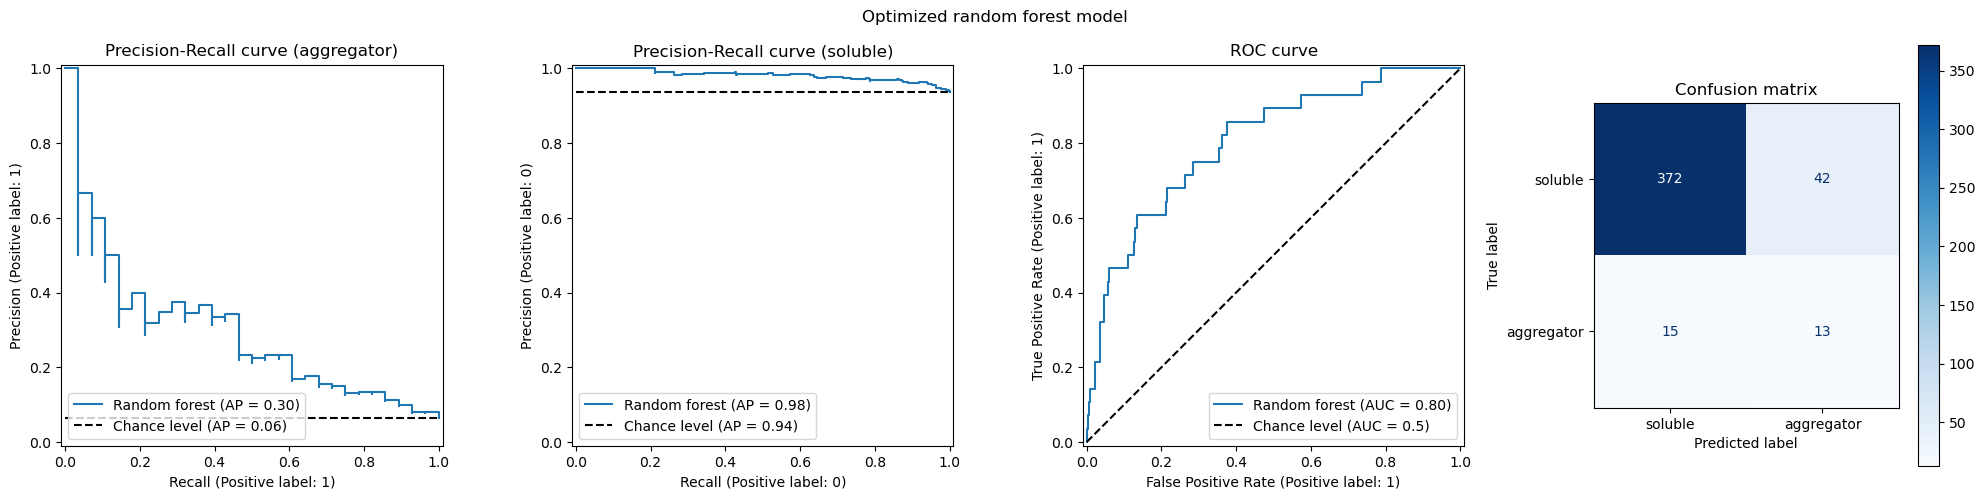

In [29]:
print(forest_search.best_estimator_)
print(f'Balanced accuracy: {balanced_accuracy_score(y1_val, forest_search.predict(Xset_val))}\n')

plot_model(forest_search)  # max_depth=7 gives specificity of 0.5

                     feature_importance
n_aggregator_motifs            0.000563
Specificity 0.4642857142857143
Sensitivity 0.8985507246376812


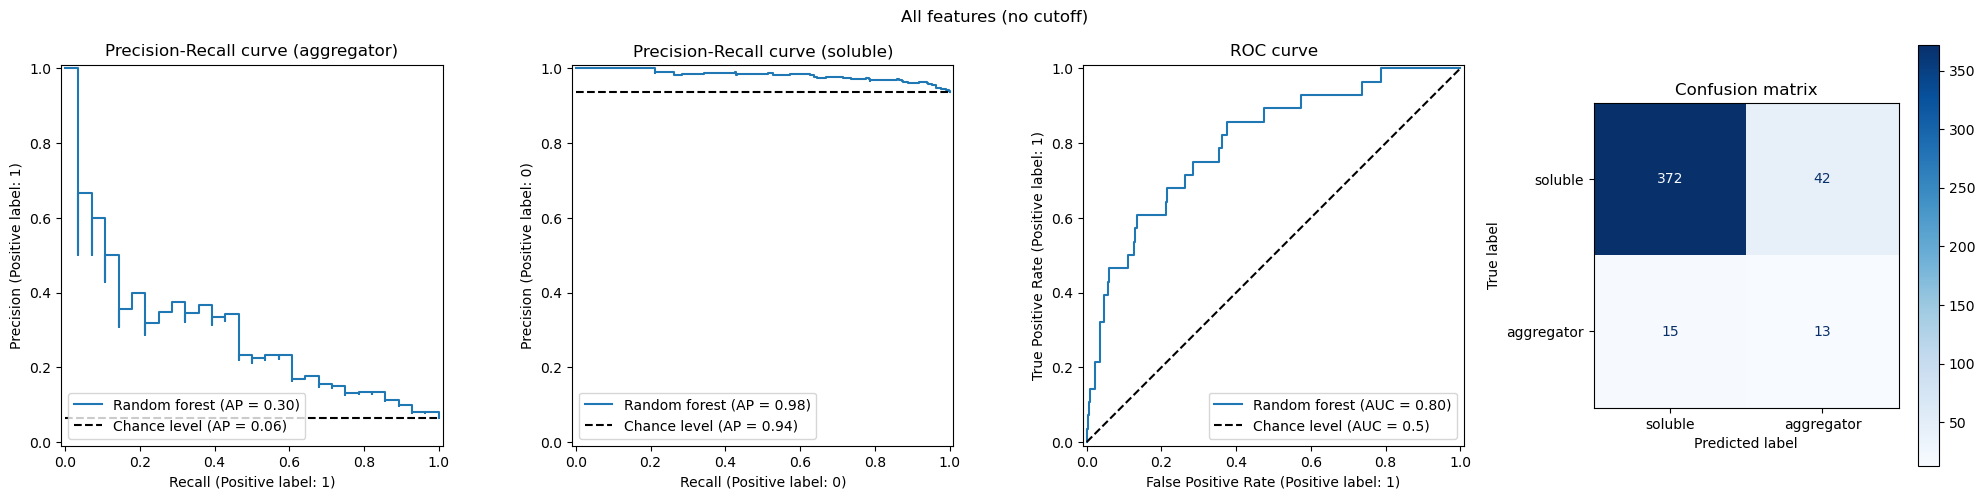

81 features (cutoff=0): 0.716
['isoelectric_point_x', 'max_NX', 'LHPpred', 'length', 'hydr_count', 'polar_count', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed', 'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed', 'Aromaticity', 'Instability_index', 'charge_at_7', 'charge_at_5', 'HSP', 'PTM_UP', 'Citrullination_UP', 'Lipoprotein_UP', 'ISGylation_UP', 'Acetylation_all', 'Glycosylation_all', 'Methylation_all', 'Nitrosylation_all', 'Palmitoylation_all', 'Phosphorylation_all', 'SUMOylation_all', 'Ubiquitination_all', 'Phosphorylation_MSD', 'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD', 'Acetylation_MSD', 'Palmitoylation_MSD', 'Methylation_MSD', 'coiled_coil', 'RRM', 'transmembr

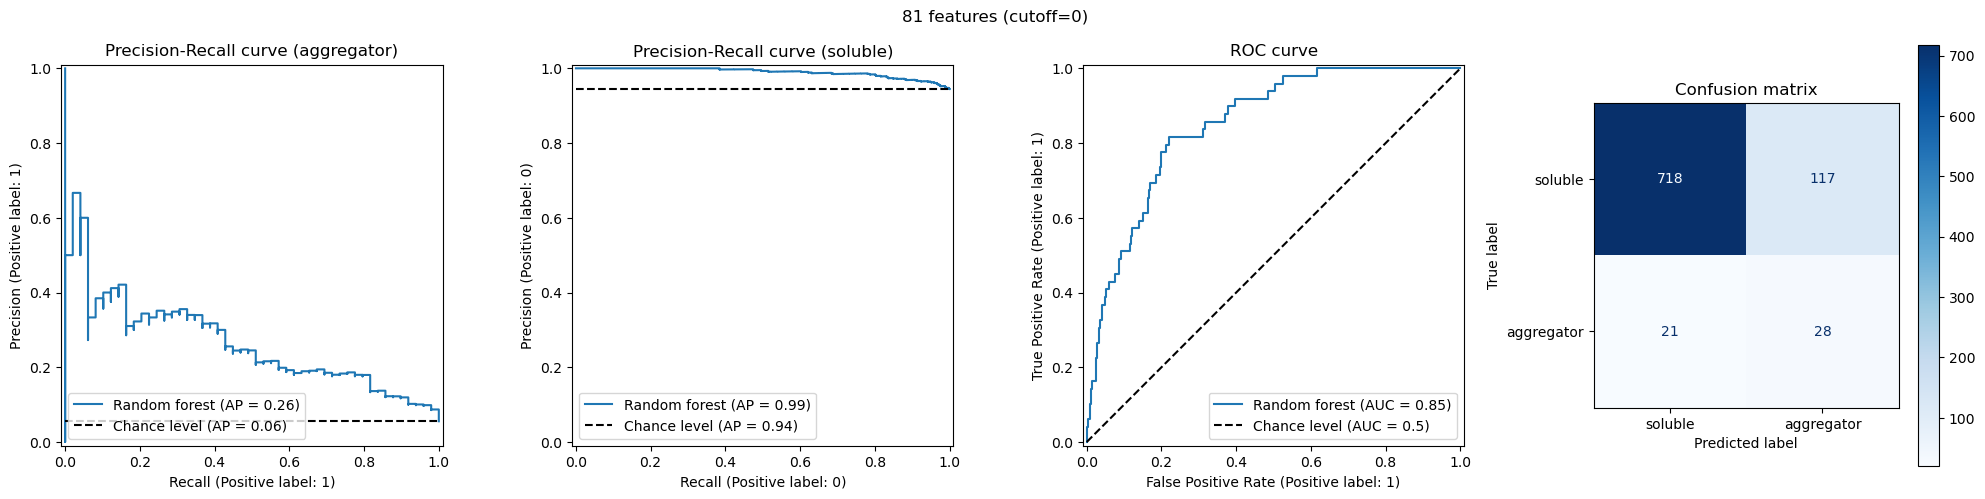

72 features (cutoff=0.0005): 0.724
['isoelectric_point_x', 'max_NX', 'LHPpred', 'length', 'hydr_count', 'polar_count', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed', 'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed', 'Aromaticity', 'Instability_index', 'charge_at_7', 'charge_at_5', 'PTM_UP', 'Acetylation_all', 'Methylation_all', 'Nitrosylation_all', 'Palmitoylation_all', 'Phosphorylation_all', 'SUMOylation_all', 'Ubiquitination_all', 'Phosphorylation_MSD', 'Glycosylation_MSD', 'SUMOylation_MSD', 'Methylation_MSD', 'RRM', 'transmembrane', 'TMHMM', 'Polar_exposed', 'Hydrophobic_exposed', 'n_aggregator_motifs']
Specificity 0.5714285714285714
Sensitivity 0.8766467065868263


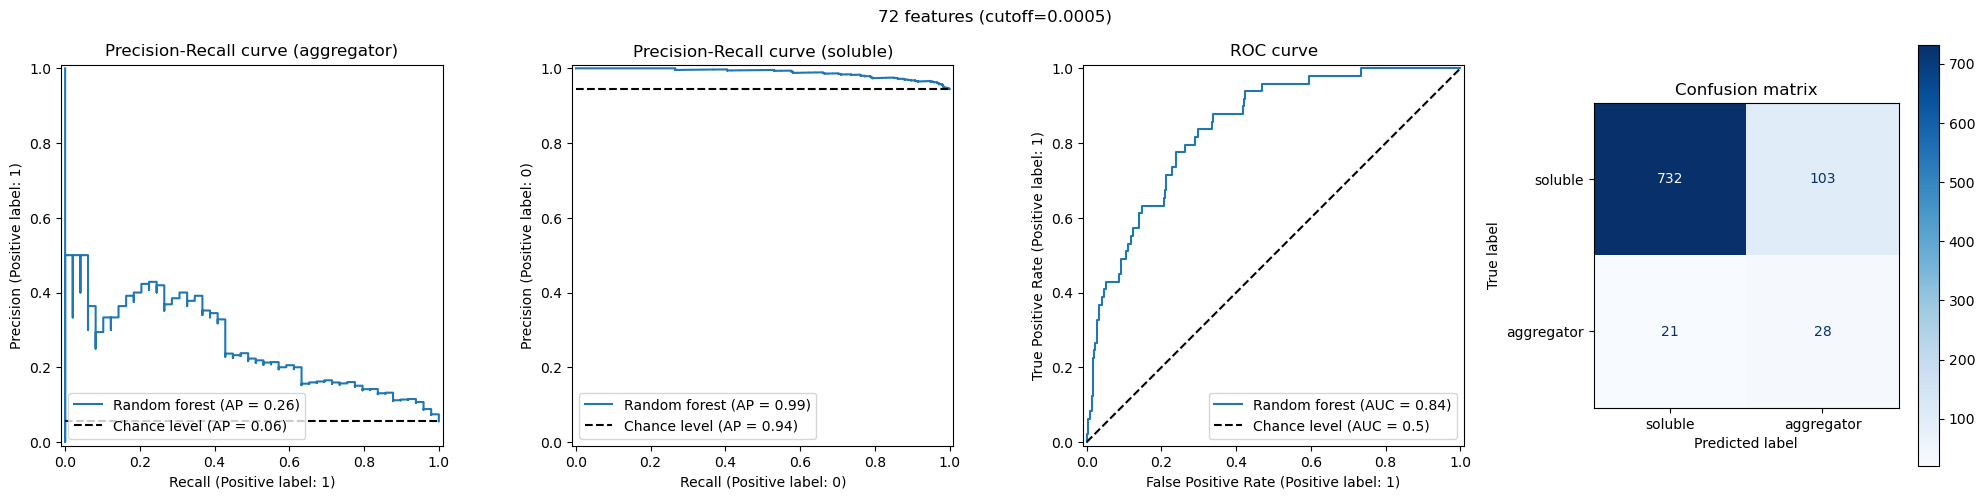

54 features (cutoff=0.005): 0.704
['isoelectric_point_x', 'max_NX', 'LHPpred', 'length', 'hydr_count', 'polar_count', 'helix', 'turn', 'sheet', 'A', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'rhsa_netsurfp2', 'disorder', 'A_exposed', 'D_exposed', 'E_exposed', 'F_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'N_exposed', 'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed', 'Aromaticity', 'Instability_index', 'charge_at_7', 'charge_at_5', 'Methylation_all', 'SUMOylation_all', 'transmembrane', 'Polar_exposed', 'Hydrophobic_exposed']
Specificity 0.5306122448979592
Sensitivity 0.8778443113772455


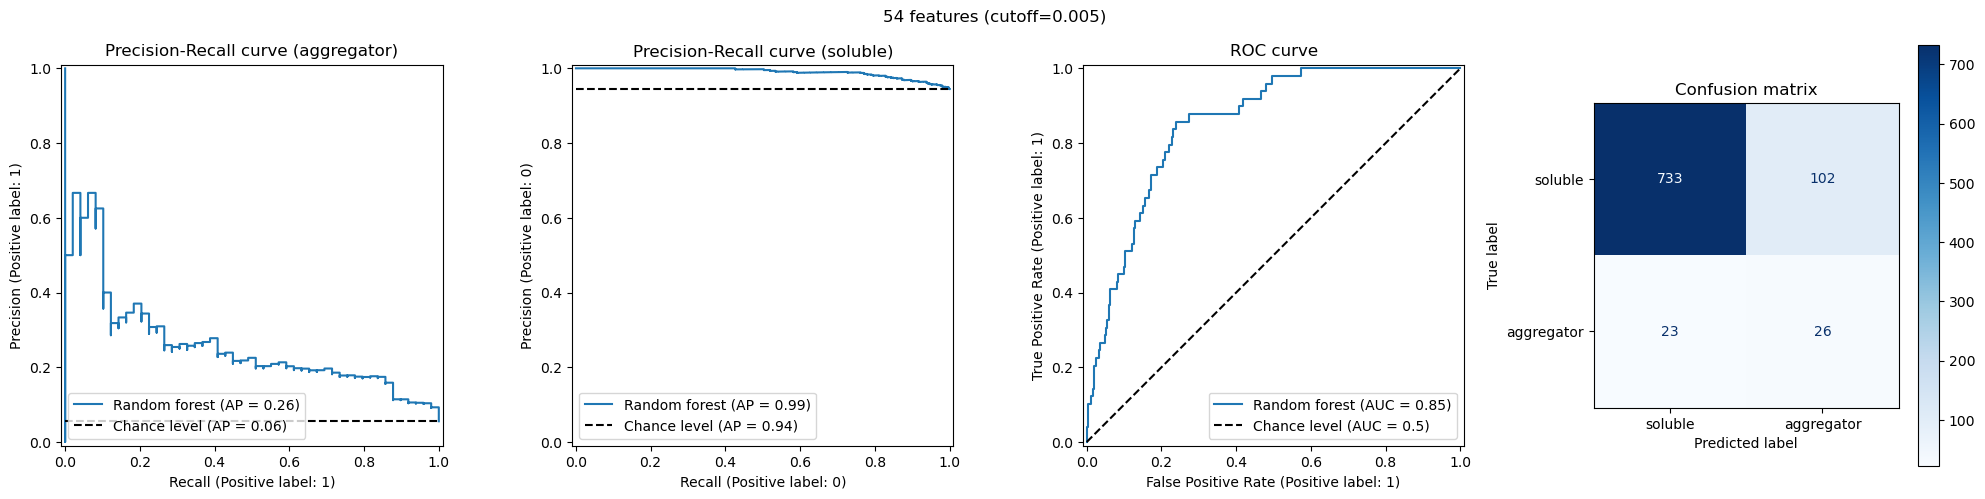

10 features (cutoff=0.025): 0.730
['LHPpred', 'length', 'hydr_count', 'turn', 'rhsa_netsurfp2', 'disorder', 'Instability_index', 'charge_at_5', 'SUMOylation_all', 'transmembrane']
Specificity 0.6122448979591837
Sensitivity 0.8479041916167664


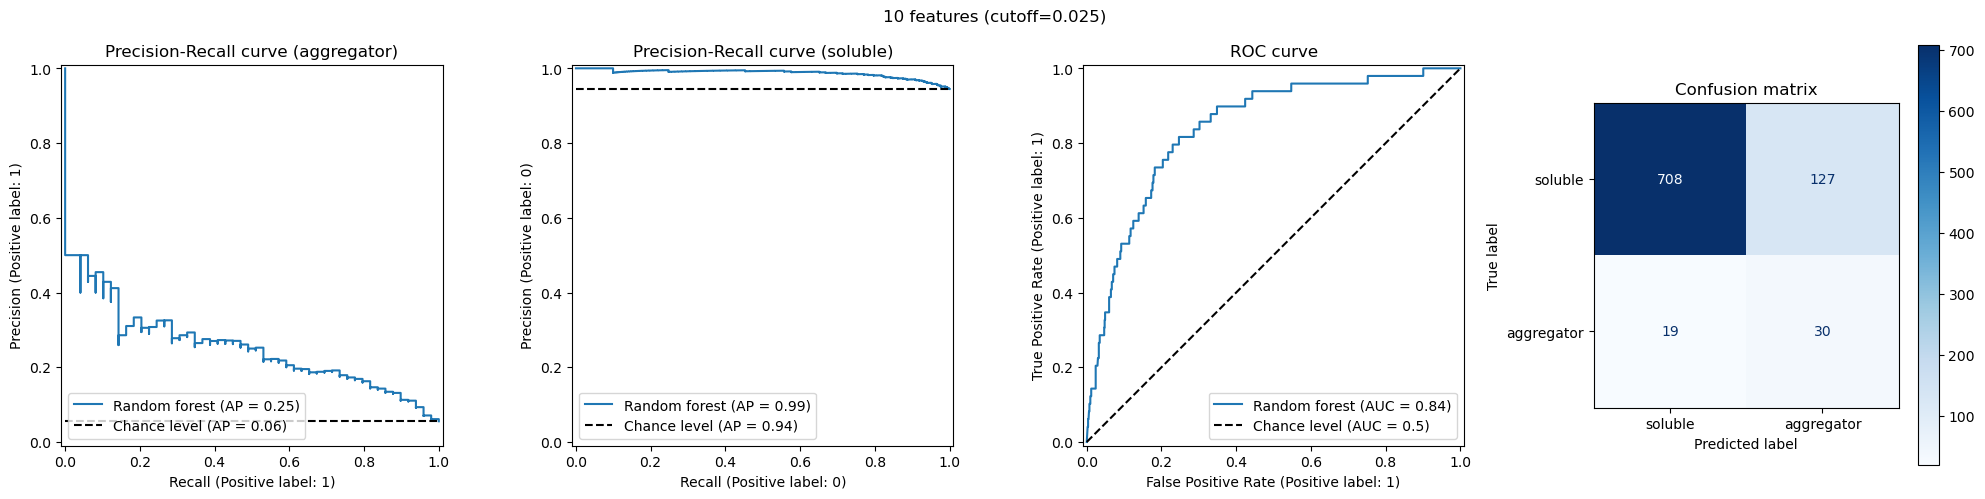

4 features (cutoff=0.05): 0.740
['hydr_count', 'disorder', 'Instability_index', 'SUMOylation_all']
Specificity 0.6530612244897959
Sensitivity 0.8263473053892215


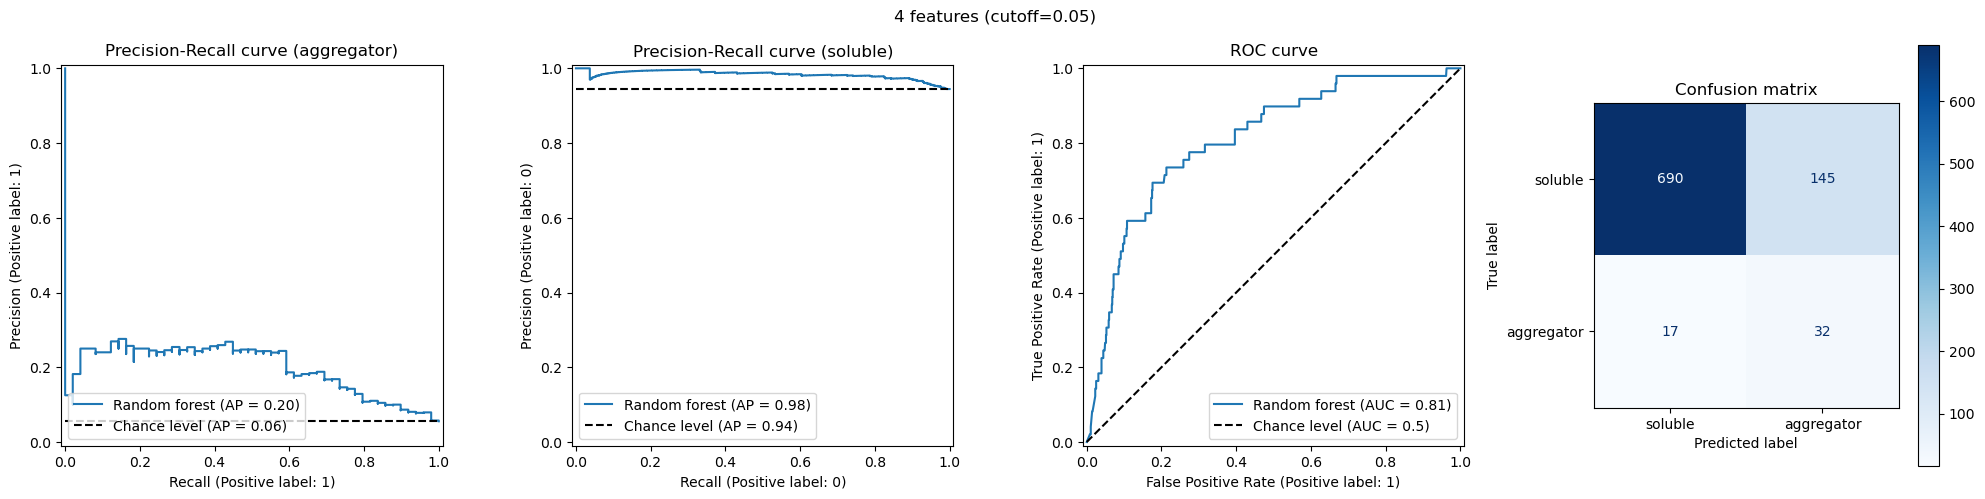

In [30]:
# Forest classifier with optimized parameters
optim_forest = RandomForestClassifier(max_depth=7, n_jobs=-1, random_state=seed).fit(Xset_train_oversampled, y1_train_oversampled)
# Generate feature importances
feature_importances = pd.DataFrame(optim_forest.feature_importances_, Xset.columns, columns=['feature_importance'])
# Print importance of added feature
print(feature_importances.loc[['n_aggregator_motifs']])
# Plot model
plot_model(optim_forest, f'All features (no cutoff)')
# Remove features with importance below cutoff
for cutoff in [0, 0.0005, 0.005, 0.025, 0.05]:
    # Select only features deemed important (above cutoff) and use them to train a new model
    important_features = feature_importances[feature_importances.feature_importance > cutoff].index
    Xset_important = numeric_df[important_features]
    y1_important = numeric_df['set'].apply(convert_to_codes)

    # Split data
    Xset_important_train, Xset_important_val_test, y1_important_train, y1_important_val_test = train_test_split(Xset_important, y1_important, test_size=0.40, random_state=seed)
    Xset_important_val, Xset_important_test, y1_important_val, y1_important_test = train_test_split(Xset_important_val_test, y1_important_val_test, test_size=0.50, random_state=seed)

    # Oversample
    ros = RandomOverSampler(random_state=seed)
    Xset_important_train, y1_important_train = ros.fit_resample(Xset_important_train, y1_important_train)

    # Fit model
    forest_oversampled_important = RandomForestClassifier(max_depth=6, n_estimators=50, n_jobs=-1, random_state=seed).fit(Xset_important_train, y1_important_train)
    print(f'{len(important_features)} features ({cutoff=}):', f'{balanced_accuracy_score(y1_important_val, forest_oversampled_important.predict(Xset_important_val)):.3f}')
    print(list(important_features))
    plot_model(forest_oversampled_important, f'{len(important_features)} features ({cutoff=})', [Xset_important_val, y1_important_val])

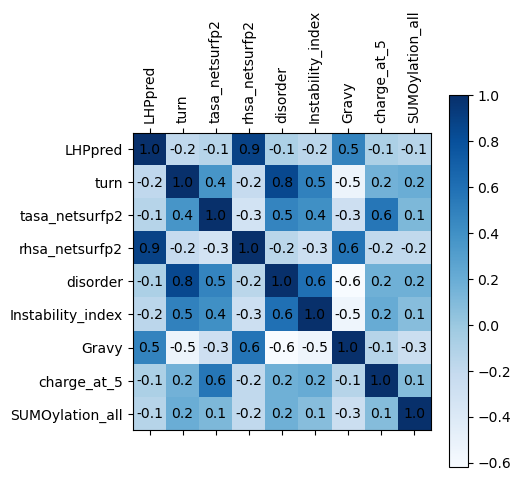

In [31]:
# Show correlations between the top 9 features
correlations_top9 = df[['LHPpred', 'turn', 'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'Instability_index', 'Gravy', 'charge_at_5', 'SUMOylation_all']].corr()
plt.matshow(correlations_top9, cmap='Blues')
for (i, j), z in np.ndenumerate(correlations_top9):
    plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.xticks(range(9), labels=list(correlations_top9.columns), rotation=90)
plt.yticks(range(9), labels=list(correlations_top9.columns))
plt.colorbar()

# Logistic regression

/home/freekdek/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/freekdek/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Stratified accuracy: 0.4975845410628019
Oversampled accuracy: 0.4975845410628019
Undersampled accuracy: 0.6590752242926157


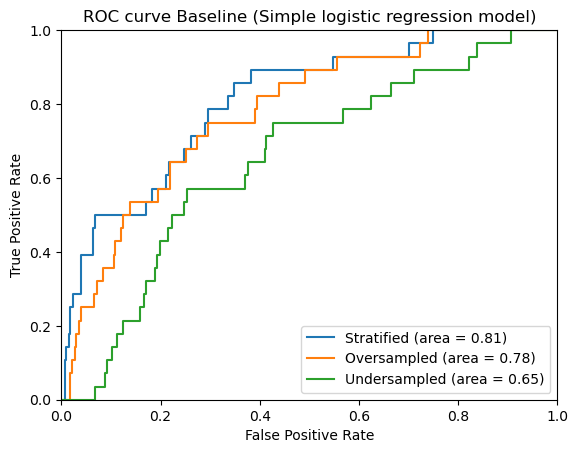

In [32]:
from sklearn.linear_model import LogisticRegression

# stratified
logistic_model = LogisticRegression()
logistic_model.fit(Xset_train, y1_train)
log_pred = logistic_model.predict(Xset_test)

log_accuracy = balanced_accuracy_score(y1_test, log_pred)
print("Stratified accuracy:", log_accuracy)

# oversampled
logistic_model_oversampled = LogisticRegression()
logistic_model_oversampled.fit(Xset_train_oversampled, y1_train_oversampled)
log_pred_ov = logistic_model.predict(Xset_test)

log_accuracy_ov = balanced_accuracy_score(y1_test, log_pred_ov)
print("Oversampled accuracy:", log_accuracy_ov)

# undersampled
logistic_model_undersampled = LogisticRegression()
logistic_model_undersampled.fit(Xset_train_undersampled, y1_train_undersampled)
log_pred_un = logistic_model_undersampled.predict(Xset_test)

log_accuracy_un = balanced_accuracy_score(y1_test, log_pred_un)
print("Undersampled accuracy:", log_accuracy_un)

plot_roc(
    (logistic_model, logistic_model_oversampled, logistic_model_undersampled),
    (Xset_val.values, Xset_val.values, Xset_val.values),
    (y1_val, y1_val, y1_val, y1_val),
    ('stratified', 'oversampled', 'undersampled'),
    f' Baseline (Simple logistic regression model)'
)
plt.savefig("baseline_roc.png")
plt.show()

# Permutation feature importance

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.base import clone
from copy import deepcopy
import numpy as np

def permutation_feature_importance(model, X, y, metric=balanced_accuracy_score, random_state=seed):
    model = deepcopy(model)
    baseline_score = metric(y, model.predict(X))
    feature_importance = np.zeros(X.shape[1])
    
    # Loop over each feature and compute importance (original accuracy - new accuracy)
    for i in range(X.shape[1]):
        X_permuted = X.copy().values
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
        permuted_score = metric(y, model.predict(X_permuted))
        feature_importance[i] = baseline_score - permuted_score
    return feature_importance

def permutation_feature_importance_NN(model, X, y, metric=balanced_accuracy_score, random_state=seed):
    model = deepcopy(model)
    
    with torch.no_grad():
        model.eval()
        test_outputs = model_oversampled(X)
        test_predictions = (test_outputs > 0.5).float()
    baseline_score = metric(y, test_predictions.numpy())
    feature_importance = np.zeros(X.shape[1])
    
    # Loop over each feature and compute importance (original accuracy - new accuracy)
    for i in range(X.shape[1]):
        X_permuted = X.clone()  # Create a deep copy of the input tensor
        X_permuted[:, i] = torch.tensor(np.random.permutation(X_permuted[:, i]), dtype=torch.float32)
        
        # Make predictions using the permutated data
        with torch.no_grad():
            model.eval()
            test_outputs = model_oversampled(X_permuted)
            test_predictions = (test_outputs > 0.5).float()
        permuted_score = metric(y, test_predictions.numpy())
        feature_importance[i] = baseline_score - permuted_score
    return feature_importance

In [34]:
# permutation importance for logistic regression (baseline)
importance_features_log = permutation_feature_importance(logistic_model_oversampled, Xset_test, y1_test, metric=balanced_accuracy_score, random_state=seed)

for cutoff in [0, 0.0005, 0.005, 0.025, 0.05]:
    print(f"{cutoff = }")
    for feature, score in zip(Xset_train.columns, importance_features_log):
        if score > cutoff:
            print(f"Feature {feature}: Importance score = {score}")

cutoff = 0
Feature isoelectric_point_x: Importance score = 0.05020703933747406
Feature max_NX: Importance score = 0.06323326432022092
Feature charge_at_5: Importance score = 0.0357142857142857
Feature Nitrosylation_all: Importance score = 0.0012077294685990392
Feature SUMOylation_all: Importance score = 0.07867494824016563
Feature Phosphorylation_MSD: Importance score = 0.0012077294685990392
Feature SUMOylation_MSD: Importance score = 0.0012077294685990392
cutoff = 0.0005
Feature isoelectric_point_x: Importance score = 0.05020703933747406
Feature max_NX: Importance score = 0.06323326432022092
Feature charge_at_5: Importance score = 0.0357142857142857
Feature Nitrosylation_all: Importance score = 0.0012077294685990392
Feature SUMOylation_all: Importance score = 0.07867494824016563
Feature Phosphorylation_MSD: Importance score = 0.0012077294685990392
Feature SUMOylation_MSD: Importance score = 0.0012077294685990392
cutoff = 0.005
Feature isoelectric_point_x: Importance score = 0.05020703

/home/freekdek/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/freekdek/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/freekdek/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/freekdek/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/freekdek/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature na

Specificity 0.6428571428571429
Sensitivity 0.7729468599033816


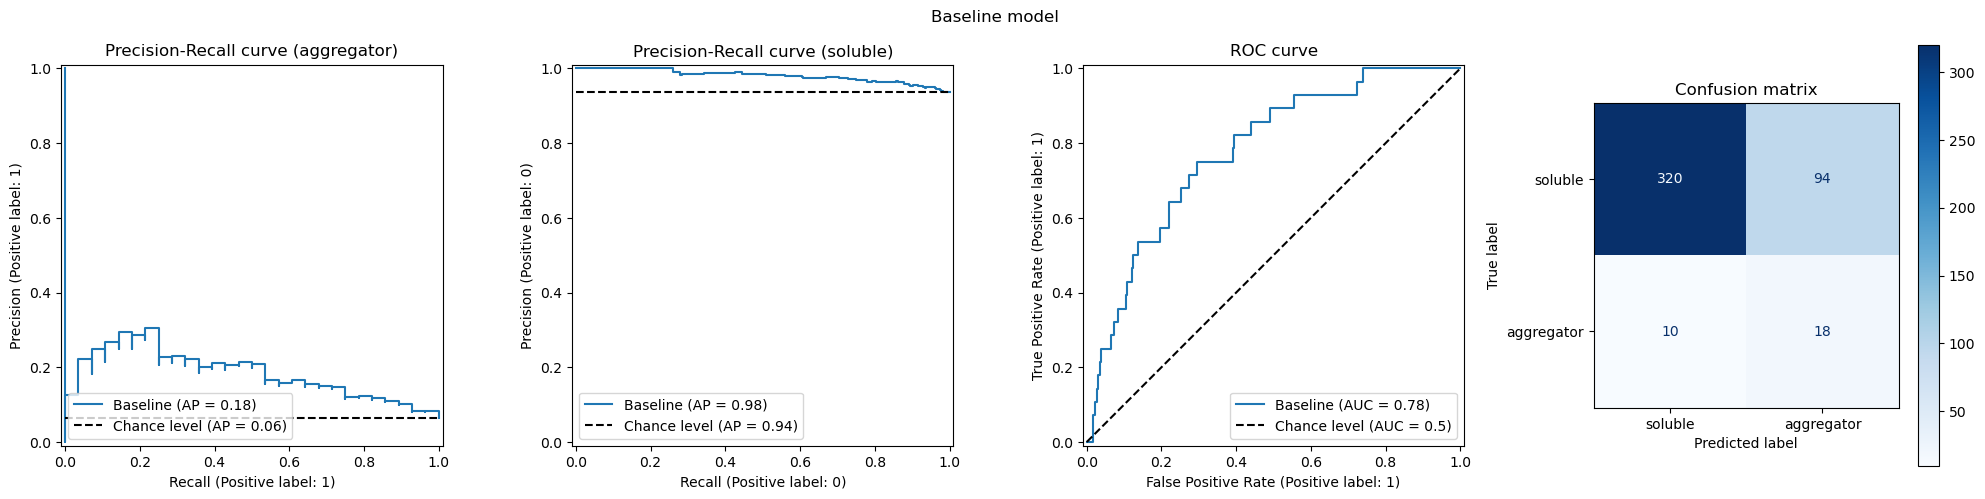

In [35]:
plot_model_baseline(logistic_model_oversampled)

In [36]:
# Permutation feature importance for KNN
# knn_oversampled = KNeighborsClassifier(n_neighbors=65)
# knn_oversampled.fit(Xset_train_oversampled.values, y1_train_oversampled)
importance_features_knn = permutation_feature_importance(knn_oversampled, Xset_test, y1_test, metric=balanced_accuracy_score, random_state=seed)

for cutoff in [0, 0.0005, 0.005, 0.025, 0.05]:
    print(f"{cutoff = }")
    for feature, score in zip(Xset_train.columns, importance_features_knn):
        if score > cutoff:
            print(f"Feature {feature}: Importance score = {score}")

/home/freekdek/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


cutoff = 0
Feature isoelectric_point_x: Importance score = 0.0012077294685990392
Feature max_NX: Importance score = 0.12620772946859904
Feature LHPpred: Importance score = 0.06392339544513459
Feature length: Importance score = 0.017857142857142905
Feature Instability_index: Importance score = 0.0714285714285714
Feature charge_at_7: Importance score = 0.008454106280193274
Feature charge_at_5: Importance score = 0.10231193926846105
cutoff = 0.0005
Feature isoelectric_point_x: Importance score = 0.0012077294685990392
Feature max_NX: Importance score = 0.12620772946859904
Feature LHPpred: Importance score = 0.06392339544513459
Feature length: Importance score = 0.017857142857142905
Feature Instability_index: Importance score = 0.0714285714285714
Feature charge_at_7: Importance score = 0.008454106280193274
Feature charge_at_5: Importance score = 0.10231193926846105
cutoff = 0.005
Feature max_NX: Importance score = 0.12620772946859904
Feature LHPpred: Importance score = 0.06392339544513459
F

Specificity 0.7142857142857143


/home/freekdek/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/home/freekdek/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/home/freekdek/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/home/freekdek/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/home/freekdek/miniconda3/envs/deep_learning/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature nam

Sensitivity 0.7004830917874396


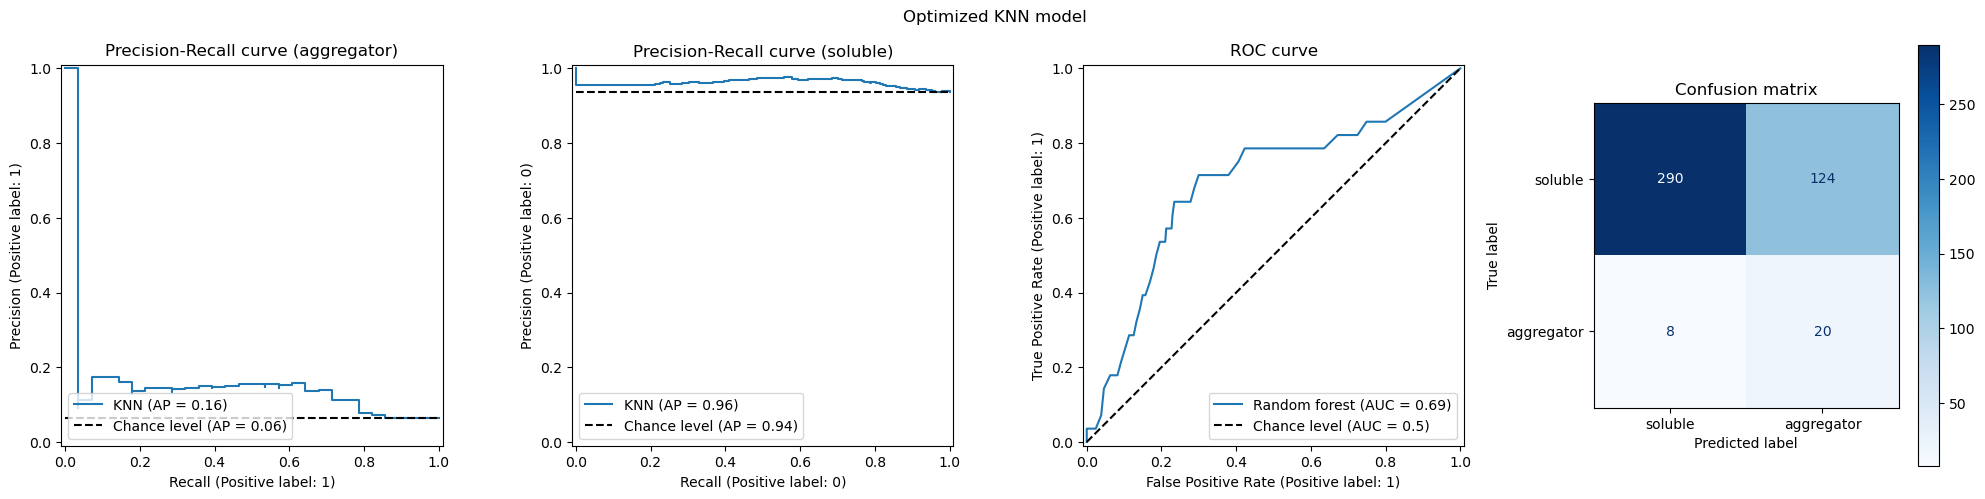

In [37]:
plot_model_KNN(knn_oversampled)

In [38]:
# permutation feature importance for feedforward NN
importance_features_ffnn = permutation_feature_importance_NN(model_oversampled, X_set_test_tensor, y_set_test_tensor, metric=balanced_accuracy_score, random_state=seed)

for cutoff in [0, 0.0005, 0.005, 0.025, 0.05]:
    print(f"{cutoff = }")
    for feature, score in zip(Xset_train.columns, importance_features_ffnn):
        if score > cutoff:
            print(f"Feature {feature}: Importance score = {score}")

cutoff = 0
Feature sheet: Importance score = 0.01061076604554867
Feature N: Importance score = 0.0012077294685990392
Feature P: Importance score = 0.0012077294685990392
Feature disorder: Importance score = 0.01061076604554867
Feature Instability_index: Importance score = 0.060559006211180155
Feature charge_at_5: Importance score = 0.07841614906832306
Feature PTM_UP: Importance score = 0.0024154589371980784
Feature Lipoprotein_UP: Importance score = 0.017857142857142905
Feature NEDDylation_UP: Importance score = 0.0012077294685990392
Feature SUMOylation_all: Importance score = 0.017857142857142905
Feature Ubiquitination_all: Importance score = 0.0012077294685990392
Feature Acetylation_MSD: Importance score = 0.0036231884057971175
Feature Palmitoylation_MSD: Importance score = 0.02268806073153906
Feature Methylation_MSD: Importance score = 0.015441683919944826
Feature coiled_coil: Importance score = 0.0012077294685990392
Feature TMHMM: Importance score = 0.017857142857142905
cutoff = 0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Specificity 0.9642857142857143
Sensitivity 0.30434782608695654


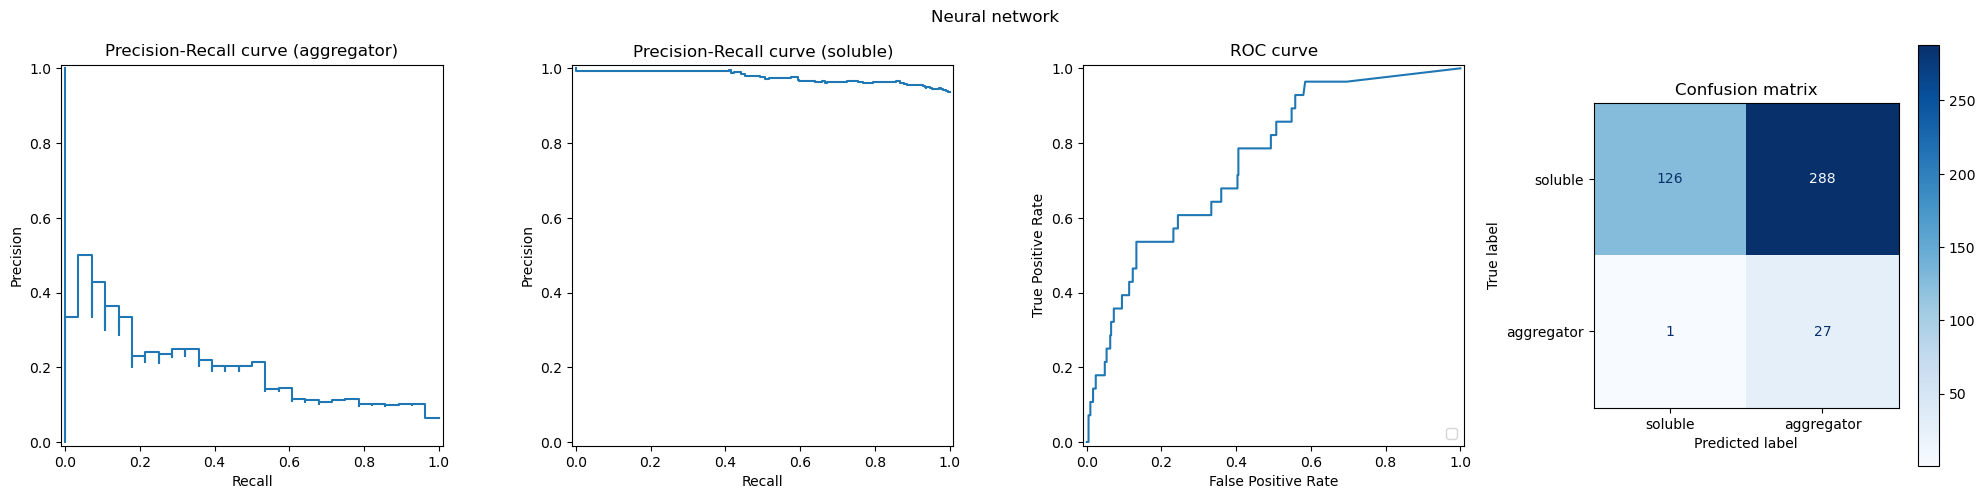

[CV 1/5] END max_depth=8, max_features=8, min_samples_split=8, n_estimators=100, random_state=42; AUC: (test=0.999) bal_accuracy: (test=0.949) sensitivity: (test=0.899) specificity: (test=1.000) total time=   2.2s
[CV 3/5] END max_depth=8, max_features=8, min_samples_split=8, n_estimators=150, random_state=42; AUC: (test=0.999) bal_accuracy: (test=0.956) sensitivity: (test=0.913) specificity: (test=1.000) total time=   2.6s
[CV 1/5] END max_depth=8, max_features=8, min_samples_split=10, n_estimators=100, random_state=42; AUC: (test=0.999) bal_accuracy: (test=0.951) sensitivity: (test=0.902) specificity: (test=1.000) total time=   2.3s
[CV 4/5] END max_depth=8, max_features=8, min_samples_split=10, n_estimators=150, random_state=42; AUC: (test=0.999) bal_accuracy: (test=0.955) sensitivity: (test=0.911) specificity: (test=1.000) total time=   2.7s
[CV 1/5] END max_depth=8, max_features=8, min_samples_split=12, n_estimators=100, random_state=42; AUC: (test=0.999) bal_accuracy: (test=0.951

In [39]:
plot_model_nn(model_oversampled)